**Semantic Segmentation**: In semantic segmentation, we assign a class label (e.g. dog, cat, person, background, etc.) to every pixel in the image.
**Object Detection**: In object detection, we assign a class label to bounding boxes that contain objects.
A very natural idea is to combine the two together. We want to only identify a bounding box around an object, and we want to find which of the pixels inside the bounding box belong to the object.

In other words, we want a mask that indicates ( using color or grayscale values ) which pixels belong to the same object. An example is shown below:

The class of algorithms that produce the above mask are called **Instance Segmentation** algorithms. Mask R-CNN is one such algorithm.

Instance segmentation and semantic segmentation differ in two ways:

In semantic segmentation, every pixel is assigned a class label, while in instance segmentation, that is not the case.
We do not tell the instances of the same class apart in semantic segmentation. For example, all pixels belonging to the “person” class in semantic segmentation will be assigned the same color/value in the mask. In instance segmentation, they are assigned different values, and we can tell them which pixels correspond to which person. We can see this in the above image.

**Input and Output**
The model expects the input to be a list of tensor images of shape (n, c , h, w), with values in the range 0-1. The size of images need not be fixed.

n is the number of images

c is the number of channels, for RGB images it is 3

h is the height of the image

w is the width of the image


The model returns
coordinates of bounding boxes,
labels of classes the model predicts to be present in the input image, scores of the labels,
the masks for each class are present in the labels.

In [3]:
from torchvision import models
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True) # метки классов те же, что и для детекции
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 107MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [8]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt # модуль для визуализации и построения графиков

def get_prediction(img_path, threshold):
  img = Image.open(img_path)
  plt.imshow(img)
  plt.axis('off')
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
      # в pred[0]: scores, labels, boxes и masks для каждого объекта
  pred_score = list(pred[0]['scores'].detach().numpy()) # список вероятностей для всех объектов
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1] # оставляем только вероятности выше 0,5 и берём последний объект с такой вероятностью
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy() # получение бинарных масок
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # получение названий классов обнаруженных объектов
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # получение координат боксов
  # фильтруем значения по порогу уверенности
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [9]:
import numpy as np
import random

def random_colour_masks(image):
      colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80,
                     190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
      r = np.zeros_like(image).astype(np.uint8)
      g = np.zeros_like(image).astype(np.uint8)
      b = np.zeros_like(image).astype(np.uint8)
      r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
      coloured_mask = np.stack([r, g, b], axis=2)
      return coloured_mask

In [29]:
import cv2

def instance_segmentation(img_path, threshold=0.5, rect_th=1, text_size=1, text_th=1):
       masks, boxes, pred_cls = get_prediction(img_path, threshold)
       img = cv2.imread(img_path)
       img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       for i in range(len(masks)):
             rgb_mask = random_colour_masks(masks[i])
             img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0) # накладываем полупрозрачную маску

             # Приведение координат к int
             x1, y1 = map(int, boxes[i][0])
             x2, y2 = map(int, boxes[i][1])

             cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=rect_th) # рисуем рямоугольничек
             cv2.putText(img,pred_cls[i], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, text_size,
             (0,0,0),thickness=text_th) # название класса
       plt.figure(figsize=(10,15))
       plt.imshow(img)
       plt.xticks([])
       plt.yticks([])
       plt.show()

In [15]:
!wget https://www.crossenlawfirm.com/src-content/uploads/2022/09/Crossen-indiana-pedestrian-laws-you-should-know.jpg -O people.jpg

--2025-11-24 09:48:25--  https://www.crossenlawfirm.com/src-content/uploads/2022/09/Crossen-indiana-pedestrian-laws-you-should-know.jpg
Resolving www.crossenlawfirm.com (www.crossenlawfirm.com)... 199.250.196.212
Connecting to www.crossenlawfirm.com (www.crossenlawfirm.com)|199.250.196.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190842 (186K) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>] 186.37K  --.-KB/s    in 0.06s   

2025-11-24 09:48:25 (3.12 MB/s) - ‘people.jpg’ saved [190842/190842]



In [20]:
instance_segmentation('./people.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [21]:
!wget https://cdn.divan.ru/img/v1/xZx7wIr5qZEMvMEPVzfQHVJqG7pWujmEGxCJ8XdLJuA/rs:fit:1920:1440:0:0/g:ce:0:0/bg:ffffff/q:85/czM6Ly9kaXZhbi9ja2VkaXRvci93aWtpLWFydGljbGUvNjM3LzYxODE4MDlkOGQ5ZDYuanBn.jpg -O kitchen.jpg

--2025-11-24 10:02:01--  https://cdn.divan.ru/img/v1/xZx7wIr5qZEMvMEPVzfQHVJqG7pWujmEGxCJ8XdLJuA/rs:fit:1920:1440:0:0/g:ce:0:0/bg:ffffff/q:85/czM6Ly9kaXZhbi9ja2VkaXRvci93aWtpLWFydGljbGUvNjM3LzYxODE4MDlkOGQ5ZDYuanBn.jpg
Resolving cdn.divan.ru (cdn.divan.ru)... 95.181.182.182, 2a11:27c0:10::182
Connecting to cdn.divan.ru (cdn.divan.ru)|95.181.182.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273731 (267K) [image/jpeg]
Saving to: ‘kitchen.jpg’

kitchen.jpg         100%[===================>] 267.32K   824KB/s    in 0.3s    

2025-11-24 10:02:02 (824 KB/s) - ‘kitchen.jpg’ saved [273731/273731]



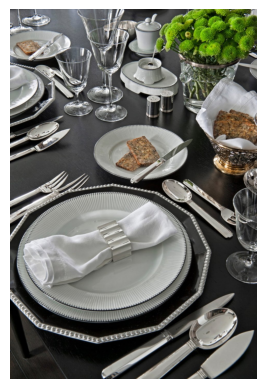

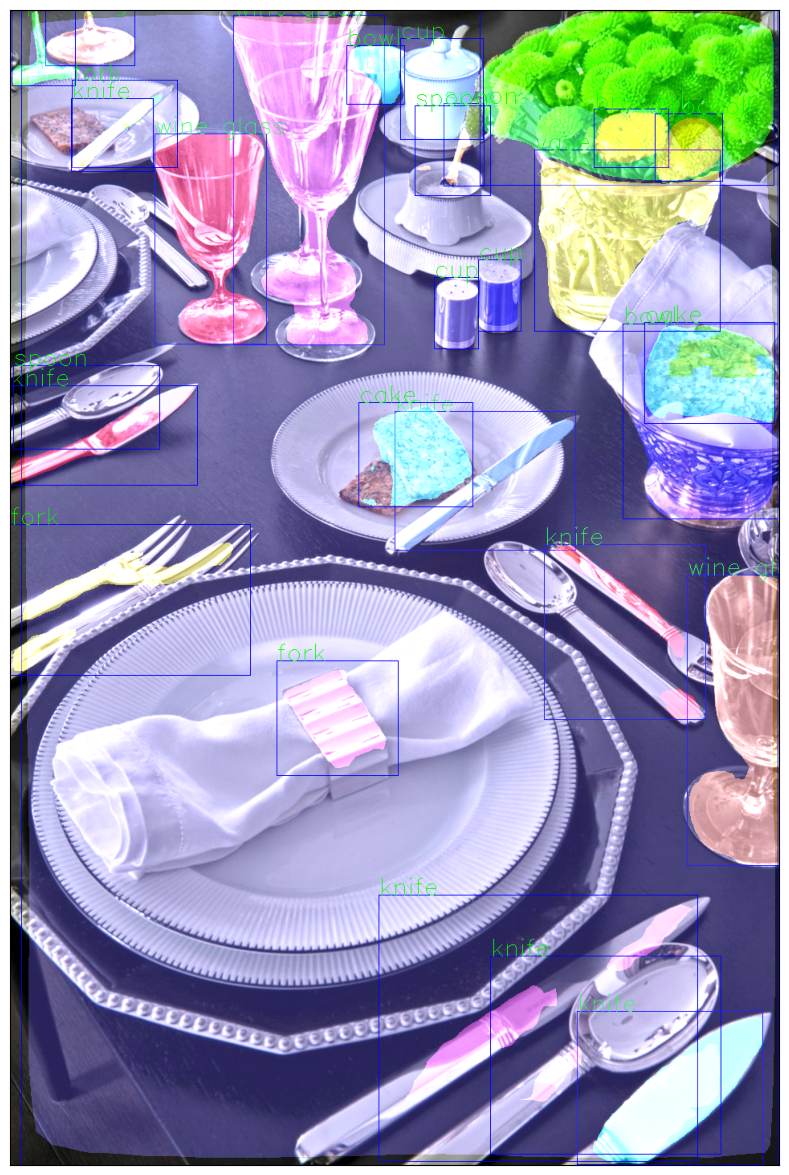

In [24]:
instance_segmentation('./kitchen.jpg')

In [26]:
!wget https://s0.rbk.ru/v6_top_pics/media/img/0/93/755929983285930.jpg -O room.jpg

--2025-11-24 10:05:17--  https://s0.rbk.ru/v6_top_pics/media/img/0/93/755929983285930.jpg
Resolving s0.rbk.ru (s0.rbk.ru)... 80.68.253.2, 185.72.229.2
Connecting to s0.rbk.ru (s0.rbk.ru)|80.68.253.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107674 (105K) [image/jpeg]
Saving to: ‘room.jpg’

room.jpg            100%[===================>] 105.15K   211KB/s    in 0.5s    

2025-11-24 10:05:18 (211 KB/s) - ‘room.jpg’ saved [107674/107674]



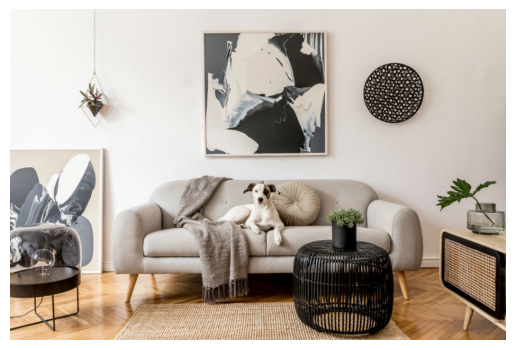

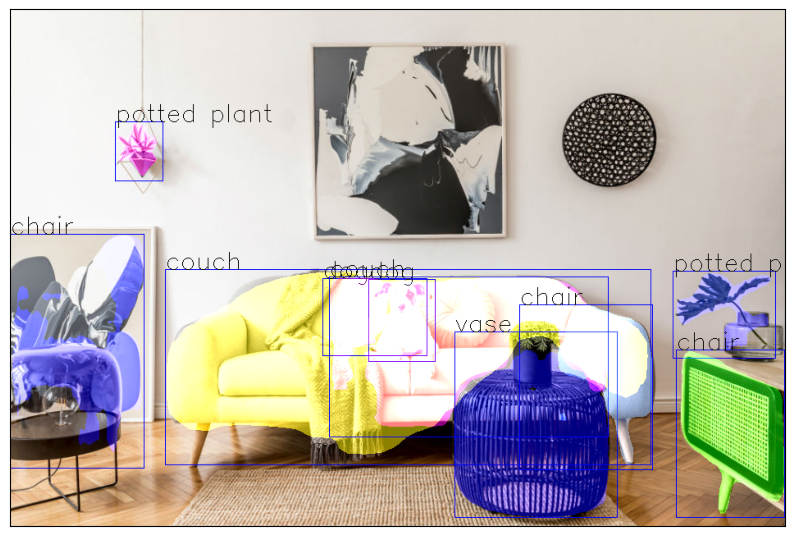

In [30]:
instance_segmentation('./room.jpg')